### Case Study 1 : Part 2 ( Feature Engineering + Machine leaning modeling )

# Google QUEST Q&A Labeling
Improving automated understanding of complex question answer content.


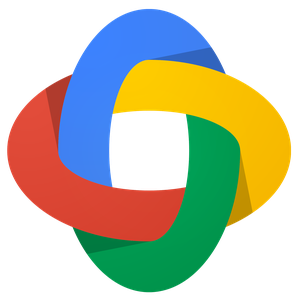

In [43]:
from io import BytesIO
import requests
from PIL import Image
response = requests.get("https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2F1.bp.blogspot.com%2F-qKqxEyuXEQo%2FVD71mHi8sDI%2FAAAAAAAAPhg%2FVwDyvAlXDnY%2Fs1600%2Frgicontransparent.png&f=1&nofb=1")
img = Image.open(BytesIO(response.content))
img.resize((300,300), Image.ANTIALIAS)

## Workflow

#### 1. Problem Statement and source
#### 2. Business Constrain and Dataset Loading
#### 3. Machine learning Formulation and Evalution mtric
#### 4. Loading Dataset
#### 5. Exploratory Data Analyses
#### 6. Insights and Findings
#### 7. Pre-processing 
#### 8. Feature engineering
#### 9. Train Test Split and Modeling
#### 10. Hyperparameter tuning 
#### 11. Results and Conclusion

In [26]:
# Ignore all your warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Loading Libraries
import datetime
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import pickle

import re
import pickle
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from tqdm import tqdm
import os
from wordcloud import WordCloud
from matplotlib_venn import venn2
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
eng_stopwords = stopwords.words('english')
import gc
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import tensorflow

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize, StandardScaler
from scipy import sparse as sp
from scipy.sparse import hstack


#### After Exploratory Data Analyses . . . .

In [2]:
# Loading the Dataset
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")
sample_submission = pd.read_csv("sample_submission.csv")

# seperating out the names of targets and dependent variables
target_vars = sample_submission.columns[1:]
x_columns = [columns for columns in train_df.columns if columns not in sample_submission.columns[1:]]

## 7.1. Preprocessing

### 7.1.1.  Preprocessing Utility Functions

In [3]:
# Preprocessing Functions
# credit : https://www.kaggle.com/urvishp80/quest-encoding-ensemble

mispell_dict = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","couldnt" : "could not","didn't" : "did not","doesn't" : "does not",
                "doesnt" : "does not","don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","havent" : "have not",
                "he'd" : "he would","he'll" : "he will","he's" : "he is","i'd" : "I would","i'd" : "I had","i'll" : "I will","i'm" : "I am",
                "isn't" : "is not","it's" : "it is","it'll":"it will","i've" : "I have","let's" : "let us","mightn't" : "might not",
                "mustn't" : "must not","shan't" : "shall not","she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not",
                "shouldnt" : "should not","that's" : "that is","thats" : "that is","there's" : "there is","theres" : "there is","they'd" : "they would",
                "they'll" : "they will","they're" : "they are","theyre":  "they are","they've" : "they have","we'd" : "we would","we're" : "we are",
                "weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are","what's" : "what is","what've" : "what have",
                "where's" : "where is","who'd" : "who would","who'll" : "who will","who're" : "who are","who's" : "who is","who've" : "who have",
                "won't" : "will not","wouldn't" : "would not","you'd" : "you would","you'll" : "you will","you're" : "you are","you've" : "you have",
                "'re": " are","wasn't": "was not","we'll":" will","didn't": "did not","tryin'":"trying"}


imp_keywords = ("R", "r", "C","c", "os", "OS")


# Counting the numeric feature and removing it
def count_digits_and_remove(text):
    """
    counting the number of occurance of digit
    
    return : text , (n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit)
    
    n_total_digit  : Total occurance of numeric feature
    n_2_digit      : Number of time 2 digit numeric feature occur
    n_2_digit      : Number of time 3 digit numeric feature occur
    n_2_digit      : Number of time 4 digit numeric feature occur
    n_5_plus_digit : Number of time more than 4 digit numeric feature occur
    
    """
    digits = re.findall(r'[0-9]+',text)

    n_total_digit = []
    n_2_digit = []
    n_3_digit = []
    n_4_digit = []
    n_5_plus_digit = []

    n_total_digit.append(len(digits))
    for digit in digits:
        if len(digit)==2:
            n_2_digit.append(digit)

        elif len(digit)==3:
            n_3_digit.append(digit)

        elif len(digit)==4:
            n_4_digit.append(digit)

        elif len(digit)>4:
            n_5_plus_digit.append(digit)
    
    # remove all the numbers
    text = re.sub(r'[0-9]+'," ",text)
            
    return text , (len(n_total_digit), len(n_2_digit), len(n_3_digit), len(n_4_digit), len(n_5_plus_digit))

#======================================================================================================================================
# Counting number of non_alpha_numeric character and removing all the special character words
def count_non_alpha_numeric_and_remove(text):  
    """ Counting number of non_alpha_numeric character(for programinng context) """
    
    # finding all the all the non_alpha_numeric char
    n_special_char = (re.findall(r"[^A-Za-z0-9 :]", text))
    
    # removing it.
    text = re.sub(r"[^A-Za-z0-9]", " ",text)
    
    return text ,len(n_special_char)

#======================================================================================================================================
# Counting the number of all capital word(maybe it would be corelated with labels) and coverting into lower string character
def count_all_cap_words_and_lower_it(text):
    
    """Finding the number of all capital word and lower it"""

    # Find all the capital words
    n_all_capital_words = (re.findall(pattern = r'([A-Z]([A-Z])+)',string=text))
    
    # converting into string into lower char string
    text = text.lower()
    
    return text , len(n_all_capital_words)

#======================================================================================================================================
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

def replace_typical_misspell(text):
    
    """De-Concatenation of words and correction of misspelled words"""
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

#======================================================================================================================================

# Return the number of links and text without html tags 
# Also return the counts of 'number of lines'  and remove it
def strip_html(text):
    """ 
    Return the number of links and clean text (without html tags) 
    Also return the counts of 'number of lines'  and remove it
    
    """
    # finding http links using regex and counting it and remove it
    n_links = (re.findall(r'http[s]?://\S+',text))
    text = re.sub(r'http[s]?://\S+'," ",text)
    
    # finding number of lines using regex and counting it and remove it
    n_lines = re.findall(r'\n',text)
    text = re.sub(r'\n', " ",text)
    
    return  text, len(n_links) , len(n_lines)

#======================================================================================================================================
# function to remove all the stopwords and words having lengths less than 3
def remove_stop_words_and_punc(text) :
    
    """ 
    Remove all the stopwords 
    Remove all the words whose length is less than 3 and not belong to important keywords(e.g. 'C','R','OS' etc)
    
    """
    # removing the words from the stop words list: 'no', 'nor', 'not'
    stops = set(stopwords.words("english"))
    stops.remove('no')
    stops.remove('nor')
    stops.remove('not')
    
    text= text.split()
    text = [w for w in text if not w in stops]    
    
    # Removing the words having length less than 3 and not the imp_keyword
    clean_text = []
    for word in text:
        if word not in imp_keywords and len(word)<3:
            pass
        else:
            clean_text.append(word)
          
        
    clean_text = " ".join(clean_text)
    return(clean_text)

#======================================================================================================================================
# function for stemming of words in text
def stem(text):
    stemmer = PorterStemmer()
    result = " ".join([ stemmer.stem(word) for word in text.split(" ")])
    return result   

In [4]:
#======================================================================================================================================
# Final text cleaning funtion  
def clean_text(text, extra_features=True, strip_html_fn=True, count_all_cap_words_and_lower_it_fn=True, replace_typical_misspell_fn=True, count_digits_and_remove_fn=True,
               count_non_alpha_numeric_and_remove_fn=True, remove_stop_words_and_punc_fn=True,stem_fn=True):
    """
    This function sequentially execute all the cleaning and preprocessing function and finaly gives cleaned text.
    Input: Boolean values of extra_features, strip_html, count_all_cap_words_and_lower_it, replace_typical_misspell, count_non_alpha_numeric_and_remove, remove_stop_words_and_punc, stem
            (by default all the input values = True)
    
    return: clean text
    
    """
    if strip_html_fn:
        # remove html tags
        clean_text, n_links, n_lines = strip_html(text)
    
    if count_all_cap_words_and_lower_it_fn:
        # Find all the capital words and covert all chars of text into lower char string
        clean_text, n_all_capital_words= count_all_cap_words_and_lower_it(clean_text)

    if replace_typical_misspell_fn:       
        # de-concatenation of words
        clean_text = replace_typical_misspell(clean_text)
    
    if count_digits_and_remove_fn:
        # count the numbers and remove it
        clean_text, (n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit) = count_digits_and_remove(clean_text)
    
    if count_non_alpha_numeric_and_remove_fn:
        # Count the number of non alpha numeric character and remove it
        clean_text, n_non_alpha_char = count_non_alpha_numeric_and_remove(clean_text)
    
    if remove_stop_words_and_punc_fn:
        # removing Stopwords and the words length less than 3(As these words mostly tend to redundant words) excpect 'C' and 'R'and 'OS' <-- programing keywords
        clean_text = remove_stop_words_and_punc(clean_text)
    
    if stem_fn:
        # stemming ( use only for BOW or TFIDF represention. Not effective for word embedding like w2v or glove)
        clean_text = stem(clean_text)
    
    # return extra_features 
    if extra_features:
        return clean_text, (n_links, n_lines, n_all_capital_words, n_non_alpha_char, n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit)
    
    else:
        return clean_text

#======================================================================================================================================================    
# This function will take dataframe and return cleaned dataframe along with extra features (This fincion will only be used for BOW nd TFIDF representaion)
def clean_data(dataframe,extra_feature=True ):
    
    """
    This function will take dataframe and return cleaned dataframe along with extra features.
    
    Input: dataframe which need to preprocess and extra_feature (by default = True)
    Return: cleaned dataframe and extra features
    
    """
    cleaned_data = []
    extra_feat = []
    
    for i in tqdm(range(dataframe.shape[0])):

        text = dataframe.iloc[i]
        
        if extra_feature:
            cleaned_text, ext_feature = clean_text(text,extra_features=extra_feature)
            cleaned_data.append(cleaned_text)
            extra_feat.append(ext_feature)
            
        else:
            cleaned_text = clean_text(text,extra_features=extra_feature)
            cleaned_data.append(cleaned_text)
            
    return cleaned_data, extra_feat

### 7.1.2. Preprocessing text features (question_title ,queston_body and answer ): Train

In [5]:
text_features_column = ['question_title', 'question_body', "answer"]

for column in text_features_column:
    print(f"\nProcessing train: {column}")
    cleaned_data, extra_features = clean_data(train_df[f'{column}'], extra_feature=True)
    train_df[f"cleaned_{column}"] = cleaned_data
    train_df[f"{column}_n_links"] = np.array(extra_features)[:,0]
    train_df[f"{column}_n_lines"] = np.array(extra_features)[:,1]
    train_df[f"{column}_n_all_capital_words"] = np.array(extra_features)[:,2]
    train_df[f"{column}_n_non_alpha_char"] = np.array(extra_features)[:,3]
    train_df[f"{column}_n_total_digit"] = np.array(extra_features)[:,4]
    train_df[f"{column}_n_2_digit"] = np.array(extra_features)[:,5]
    train_df[f"{column}_n_3_digit"] = np.array(extra_features)[:,6]
    train_df[f"{column}_n_4_digit"] = np.array(extra_features)[:,7]
    train_df[f"{column}_n_5_plus_digit"] = np.array(extra_features)[:,8]



Processing train: question_title


100%|████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:01<00:00, 3097.91it/s]



Processing train: question_body


100%|█████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:09<00:00, 639.45it/s]



Processing train: answer


100%|█████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:09<00:00, 625.16it/s]


#### Example of preprocessing

In [6]:
# Example of preprocessing
i=20
print(f"before preprocessing:\n{'-'*20}\n {train_df['question_body'][i]}")
print(f"\nafter preprocessing:\n{'-'*20}\n {train_df['cleaned_question_body'][i]}")

before preprocessing:
--------------------
 I am trying to understand what kinds of places the spam values on p 231 refer to in the 5th Edition main book for Shadowrun.

Per p 15, a sprawl is a plex, a plex is a "metropolitan complex, short for metroplex". Per Google a metroplex is " a very large metropolitan area, especially one that is an aggregation of two or more cities".  A city downtown and sprawl downtown would tend to have similar densities, but for some reason the sprawl (which includes suburbs?) has a higher spam zone noise rating (p 231).  Similarly, I'd think of a downtown as being more dense and noisy (e.g. Office buildings and street vendors) than a commercial district, e.g. an outdoor mall.  The noise ratings make me think that I am thinking about this incorrectly. What is a better way of thinking of them?


after preprocessing:
--------------------
 tri understand kind place spam valu refer edit main book shadowrun per sprawl plex plex metropolitan complex short metropl

### 7.1.3 Preprocessing text features (question_title ,queston_body and answer )-test

In [7]:
text_features_column = ['question_title', 'question_body', "answer"]

for column in text_features_column:
    print(f"\nProcessing test: {column}")
    cleaned_data, extra_features = clean_data(test_df[f'{column}'], extra_feature=True)
    test_df[f"cleaned_{column}"] = cleaned_data
    test_df[f"{column}_n_links"] = np.array(extra_features)[:,0]
    test_df[f"{column}_n_lines"] = np.array(extra_features)[:,1]
    test_df[f"{column}_n_all_capital_words"] = np.array(extra_features)[:,2]
    test_df[f"{column}_n_non_alpha_char"] = np.array(extra_features)[:,3]
    test_df[f"{column}_n_total_digit"] = np.array(extra_features)[:,4]
    test_df[f"{column}_n_2_digit"] = np.array(extra_features)[:,5]
    test_df[f"{column}_n_3_digit"] = np.array(extra_features)[:,6]
    test_df[f"{column}_n_4_digit"] = np.array(extra_features)[:,7]
    test_df[f"{column}_n_5_plus_digit"] = np.array(extra_features)[:,8]



Processing test: question_title


100%|██████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 2990.99it/s]



Processing test: question_body


100%|███████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 565.48it/s]



Processing test: answer


100%|███████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 596.69it/s]


### 7.1.4. WordCloud of (question_title ,queston_body and answer )-train after preprocessing

 1: Plot for cleaned_question_title


 2: Plot for cleaned_question_body


 3: Plot for cleaned_answer




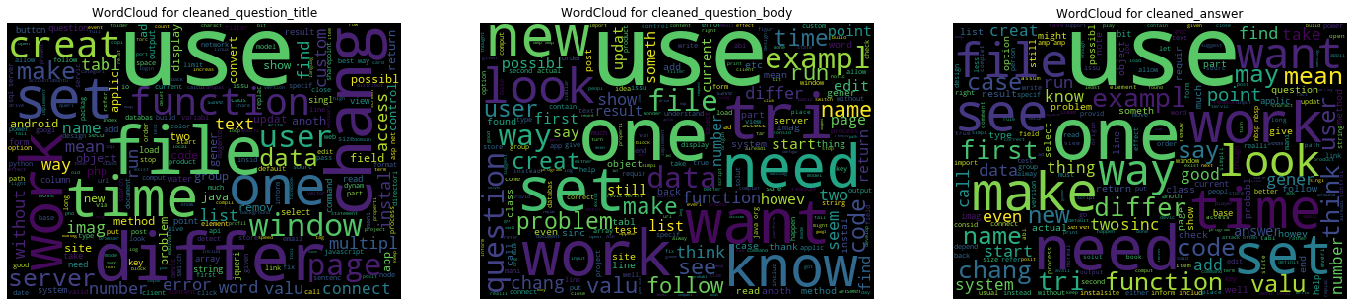

In [8]:
text_features_column = ['cleaned_question_title', 'cleaned_question_body', "cleaned_answer"]

f, (ax) = plt.subplots(1, 3, figsize=(24,6))
for idx, column in enumerate(text_features_column):
    
    wordcloud = WordCloud(
        background_color='black',
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(" ".join(train_df[f'{column}'].astype(str)))
    
    print(f" {idx+1}: Plot for {column}")
    print('\n')
    ax[idx].imshow(wordcloud)
    ax[idx].set(title=f'WordCloud for {column}')
    ax[idx].axis('off')

### 7.1.5. Distribution of length and number of word  in text (before and after preprocessing)

1: Plot for question_title


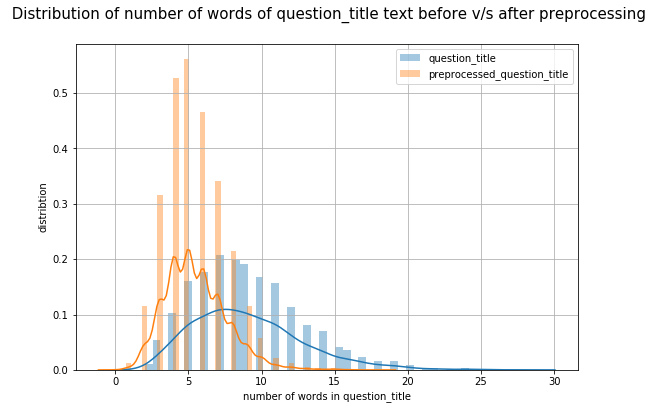

2: Plot for question_body


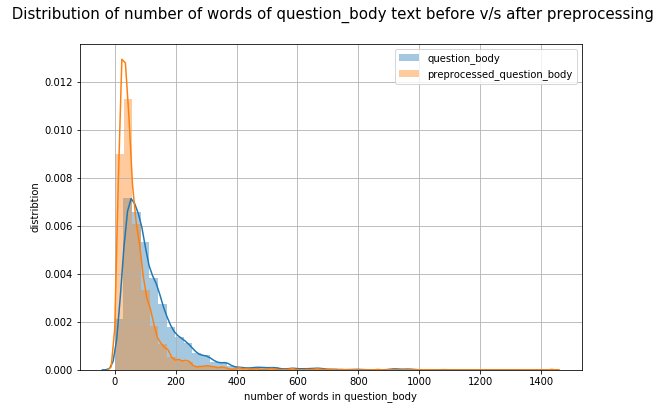

3: Plot for answer


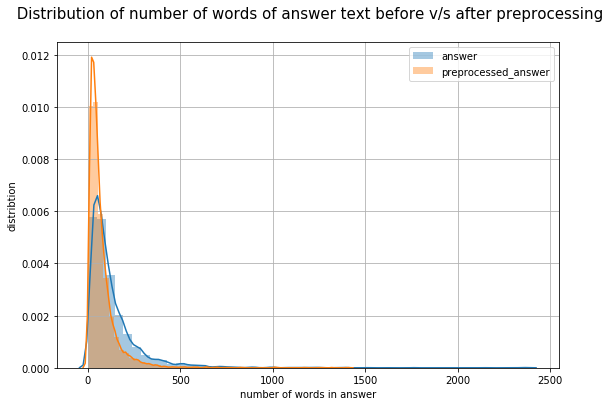

In [9]:
text_features_column = ['question_title', 'question_body', "answer"]

for idx,column in enumerate(text_features_column):
    
    # Calculating the length of text before and after preprocessing
    len_after_cleaning = train_df[f'cleaned_{column}'].apply(lambda x : len(x.split()))
    len_before_cleaning = train_df[f'{column}'].apply(lambda x : len(x.split()))
    
    # ploting
    print( f"{idx+1}: Plot for {column}")
    plt.figure(figsize=(9,6))
    sns.distplot(len_before_cleaning, label=f'{column}')
    sns.distplot(len_after_cleaning, label=f'preprocessed_{column}')
    plt.title(f" Distribution of number of words of {column} text before v/s after preprocessing\n",fontsize=15)
    plt.ylabel("distribtion")
    plt.xlabel(f"number of words in {column}")
    plt.legend()
    plt.grid()
    plt.show()

* Observation:

### 7.1.6. Preprocessing for word embedding (without stemming)

#### 7.1.6.1. Preprocessing utility function for word embedding (without stemming)

Only minor change in this function and above preprocessing function is this statement:

     "clean_text(text,extra_features= False, stem_fn=False)" at line 19

In [10]:
#======================================================================================================================================================    
# This function is only for  word embedding pre processing
# This function will take dataframe and return cleaned dataframe (This fincion will only be used for BOW nd TFIDF representaion)
def clean_data_for_embeding(dataframe ):
    
    """
    This function will take dataframe and return cleaned dataframe along with extra features.
    
    Input: dataframe which need to preprocess only for embeddings words
    Return: clean dataframe 
    
    """
    cleaned_data = []
    
    for i in tqdm(range(dataframe.shape[0])):

        text = dataframe.iloc[i]
        
        cleaned_text = clean_text(text,extra_features= False, stem_fn=False) # There is no need of extra_features to calculate again as it is already calculated
        cleaned_data.append(cleaned_text)
      
    return cleaned_data

In [11]:
# Preprocessing for word embedding (without stemming)

text_features_column = ['question_title', 'question_body', "answer"]

# For train_df
for column in text_features_column:
    print(f"\nProcessing train: {column}")
    cleaned_data = clean_data_for_embeding(train_df[f'{column}'])
    train_df[f"cleaned_{column}_for_embedding"] = cleaned_data  
    
# For test_df
for column in text_features_column:
    print(f"\nProcessing test: {column}")
    cleaned_data = clean_data_for_embeding(test_df[f'{column}']) 
    test_df[f"cleaned_{column}_for_embedding"] = cleaned_data 


Processing train: question_title


100%|████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:01<00:00, 4675.50it/s]



Processing train: question_body


100%|████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:02<00:00, 2554.02it/s]



Processing train: answer


100%|████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:02<00:00, 2565.89it/s]



Processing test: question_title


100%|██████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 4617.16it/s]



Processing test: question_body


100%|██████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 2543.04it/s]



Processing test: answer


100%|██████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 2489.89it/s]


In [12]:
# Sample preproceesing
print(f"Before preproceesing: \n{'-'*20}\n{train_df['question_body'][12]}")
print(f"After preproceesing: \n{'-'*20}\n{train_df['cleaned_question_body_for_embedding'][12]}")

Before preproceesing: 
--------------------
Here and there I read of people who set their lens to a small aperture while testing their sensor cleanness, supposedly to get the best image of dust speckles. However, the image of the on-sensor dust particles should not, to my understanding, be affected by the sharpness induced by the lens settings. Same is true for dust particle on the lens elements themselves. It makes me wonder - do these people misunderstand the theory of how the optical system work, or am I missing something?

After preproceesing: 
--------------------
read people set lens small aperture testing sensor cleanness supposedly get best image dust speckles however image sensor dust particles not understanding affected sharpness induced lens settings true dust particle lens elements makes wonder people misunderstand theory optical system work missing something


#### 7.1.6.2 WordCloud of ('cleaned_question_title_for_embedding', 'cleaned_question_body_for_embedding', "cleaned_answer_for_embedding")-train after preprocessing

 1: Plot for cleaned_question_title_for_embedding


 2: Plot for cleaned_question_body_for_embedding


 3: Plot for cleaned_answer_for_embedding




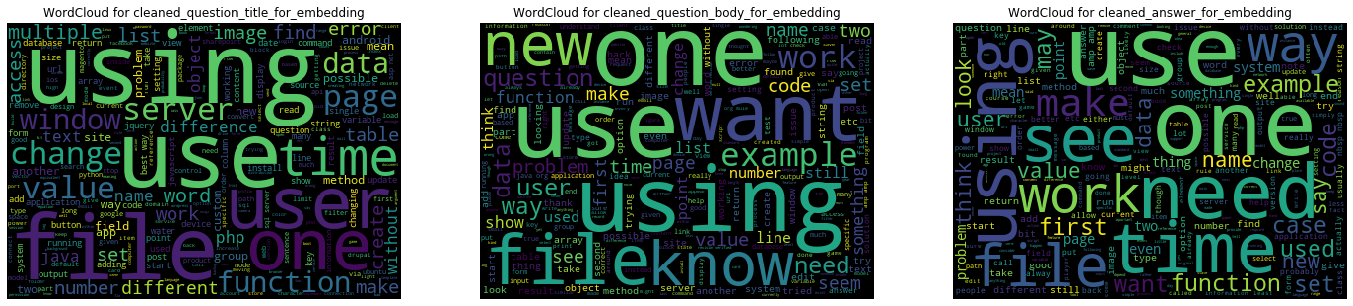

In [13]:
text_features_column = ['cleaned_question_title_for_embedding', 'cleaned_question_body_for_embedding', "cleaned_answer_for_embedding"]

f, (ax) = plt.subplots(1, 3, figsize=(24,6))
for idx, column in enumerate(text_features_column):
    
    wordcloud = WordCloud(
        background_color='black',
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(" ".join(train_df[f'{column}'].astype(str)))
    
    print(f" {idx+1}: Plot for {column}")
    print('\n')
    ax[idx].imshow(wordcloud)
    ax[idx].set(title=f'WordCloud for {column}')
    ax[idx].axis('off')

## 8. Feature Engineering

### 8.1 Feature Engineering of Text feature ('question_title', 'question_body', "answer")

### 8.1.1. Feature Engineering: Text to Image Feature

In [14]:
# Function to convert text into image feature
def convert_to_image_feat(text):
    
    # Encoding text into bytes
    b = text.encode('utf16')
    
    # Decoding into pixel intensity or image feat
    image_feat_array = np.frombuffer(b,dtype = np.uint8)
    
    return image_feat_array


# Function to convert dataframe of text into image feature
def text_dataframe_to_image_feat_pipeline(dataframe, Padding_width=None):
    
    """
    input         : dataframe containing text data
    Padding_width : length to pad (by default=None)
                    if None ; Padding_width = maximum length of all sequences
                    
    return        : converted dataframe of text into image feature in array  
    """
    
    # Convert each text of dataframe to image feature
    text_image_features = dataframe.apply(lambda x: convert_to_image_feat(x))
    
    # Padding using keras pad_sequences
    padded_image_features_dataframe = tensorflow.keras.preprocessing.sequence.pad_sequences(text_image_features, maxlen = Padding_width, dtype='int32', padding='post')
    
    return padded_image_features_dataframe


#### 8.2.1.1. Choosing the padding size for 'question_title', 'question_body', "answer" using image_feature distribution

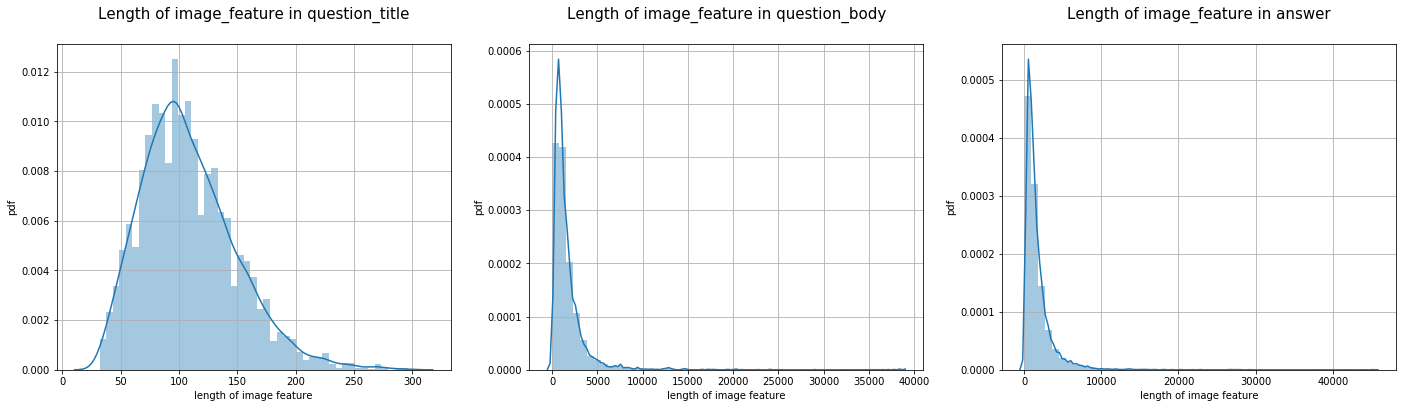

In [15]:
text_features_column = ['question_title', 'question_body', "answer"]

f, (ax) = plt.subplots(1, 3, figsize=(24, 6))
for idx, column in enumerate(text_features_column):
    
    # Calculating length of image feature of each text of datframe
    length_of_image_feaure = [len(i) for i in train_df[f'{column}'].apply(lambda x: convert_to_image_feat(x))]
    
    # Ploting
    sns.distplot(length_of_image_feaure,ax=ax[idx])
    ax[idx].set(xlabel=f"length of image feature", ylabel=f"pdf", title=f'Length of image feature in {column}\n')
    ax[idx].set_title(f'Length of image_feature in {column}\n',fontsize=15);
    ax[idx].grid()

  

#### 8.2.1.2. Finding image_features from text of 'question_title', 'question_body', "answer" 

In [16]:
# Convert question_title text to image feature and mix-max normalize it
train_question_title_padded_image_features = normalize(text_dataframe_to_image_feat_pipeline(train_df['question_title'], Padding_width=300), norm='max', axis=0) # Padding_width is choosen using distribution (for question_title )
test_question_title_padded_image_features = normalize(text_dataframe_to_image_feat_pipeline(test_df['question_title'], Padding_width=300), norm='max', axis=0) # Padding_width is choosen using distribution (for question_title )

# Convert question_body text to image feature and mix-max normalize it
train_question_body_padded_image_features = normalize(text_dataframe_to_image_feat_pipeline(train_df['question_body'], Padding_width=10000), norm='max', axis=0) # Padding_width is choosen using distribution (for question_body )
test_question_body_padded_image_features = normalize(text_dataframe_to_image_feat_pipeline(test_df['question_body'], Padding_width=10000), norm='max', axis=0) # Padding_width is choosen using distribution (for question_body )

# Convert answer text to image feature and mix-max normalize it
train_answer_padded_image_features = normalize(text_dataframe_to_image_feat_pipeline(train_df['answer'], Padding_width=10000), norm='max', axis=0) # Padding_width is choosen using distribution (for answer)
test_answer_padded_image_features = normalize(text_dataframe_to_image_feat_pipeline(test_df['answer'], Padding_width=10000), norm='max', axis=0) # Padding_width is choosen using distribution (for answer)


print(f"Shape of image_feature of question_title with padding in train: {train_question_title_padded_image_features.shape}")
print(f"Shape of image_feature of question_title with padding in test: {test_question_body_padded_image_features.shape}\n")

print(f"Shape of image_feature of question_body with padding in train: {train_question_body_padded_image_features.shape}")
print(f"Shape of image_feature of question_body with padding in test: {test_question_body_padded_image_features.shape}\n")

print(f"Shape of image_feature of answer with padding in train: {train_answer_padded_image_features.shape}")
print(f"Shape of image_feature of answer with padding in test: {test_answer_padded_image_features.shape}")

Shape of image_feature of question_title with padding in train: (6079, 300)
Shape of image_feature of question_title with padding in test: (476, 10000)

Shape of image_feature of question_body with padding in train: (6079, 10000)
Shape of image_feature of question_body with padding in test: (476, 10000)

Shape of image_feature of answer with padding in train: (6079, 1000)
Shape of image_feature of answer with padding in test: (476, 1000)


#### 8.2.1.3. sample of image feature (only for question_body)
It is interesting to see how different question_body has different image structure.

plot: 1 at index - 294


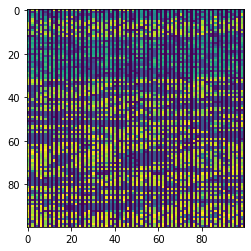

plot: 2 at index - 329


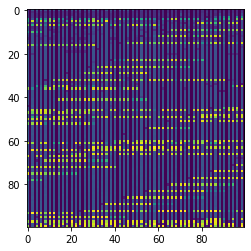

plot: 3 at index - 383


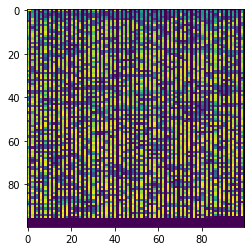

plot: 4 at index - 419


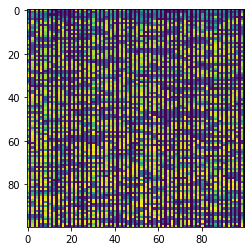

plot: 5 at index - 420


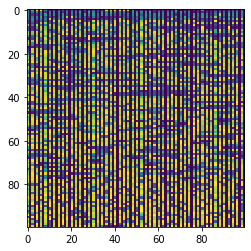

In [17]:
# Sample plot

# finding the length of image_feature of question_body
length_of_image_feaure = [len(i) for i in train_df['question_body'].apply(lambda x: convert_to_image_feat(x))]

# Ploting the image of feat where length_of_image_feaure > 9000
for idx, i in enumerate(np.where(np.array(length_of_image_feaure)>9000)[0][5:10]):
    
    print(f"plot: {idx+1} at index - {i}")
    # uncomment to see how different question_body has different image structure
    # print(train_df.question_body[i])
    
    plt.imshow((train_question_body_padded_image_features[i]).reshape(100,100))
    plt.show()

## 8.2.2. Vector Representation of text

#### 1.  BOW Representation
#### 2.  TF-idf Representation
#### 3.  W2V Representation
#### 4.  Tf-idf W2V Representation
#### 5.  Tf-idf W2V Representation using top idf score

* Note: For word Embedding we have to preprocess the text again to remove stemming as it impact the sentiment of word in Embedding badly.

### 8.2.2.1. Bag of Word(BOW) Representation

#### 1. Unigram BOW
#### 2. Bigram BOW
#### 3. Trigram BOW

#### Word Cloud

* Unigram BOW

In [121]:
# For question_title
c_vect = CountVectorizer(ngram_range=(1, 1))
train_cleaned_question_title_unigram_BOW =  c_vect.fit_transform(train_df['cleaned_question_title'])
test_cleaned_question_title_unigram_BOW = c_vect.transform(test_df['cleaned_question_title'])

# For question_body
c_vect = CountVectorizer(ngram_range=(1, 1))
train_cleaned_question_body_unigram_BOW =  c_vect.fit_transform(train_df['cleaned_question_body'])
test_cleaned_question_body_unigram_BOW = c_vect.transform(test_df['cleaned_question_body'])

# For answer
c_vect = CountVectorizer(ngram_range=(1, 1))
train_cleaned_answer_unigram_BOW =  c_vect.fit_transform(train_df['cleaned_answer'])
test_cleaned_answer_unigram_BOW = c_vect.transform(test_df['cleaned_answer'])

* Bigram BOW

In [122]:
# For question_title
c_vect = CountVectorizer(ngram_range=(1, 2))
train_cleaned_question_title_bigram_BOW =  c_vect.fit_transform(train_df['cleaned_question_title'])
test_cleaned_question_title_bigram_BOW = c_vect.transform(test_df['cleaned_question_title'])

# For question_body
c_vect = CountVectorizer(ngram_range=(1, 2))
train_cleaned_question_body_bigram_BOW =  c_vect.fit_transform(train_df['cleaned_question_body'])
test_cleaned_question_body_bigram_BOW = c_vect.transform(test_df['cleaned_question_body'])

# For answer
c_vect = CountVectorizer(ngram_range=(1, 2))
train_cleaned_answer_bigram_BOW =  c_vect.fit_transform(train_df['cleaned_answer'])
test_cleaned_answer_bigram_BOW = c_vect.transform(test_df['cleaned_answer'])

* Trigram BOW

In [ ]:
# For question_title
c_vect = CountVectorizer(ngram_range=(1, 3))
train_cleaned_question_title_trigram_BOW =  c_vect.fit_transform(train_df['cleaned_question_title'])
test_cleaned_question_title_trigram_BOW = c_vect.transform(test_df['cleaned_question_title'])

# For question_body
c_vect = CountVectorizer(ngram_range=(1, 2))
train_cleaned_question_body_trigram_BOW =  c_vect.fit_transform(train_df['cleaned_question_body'])
test_cleaned_question_body_trigram_BOW = c_vect.transform(test_df['cleaned_question_body'])

# For answer
c_vect = CountVectorizer(ngram_range=(1, 2))
train_cleaned_answer_trigram_BOW =  c_vect.fit_transform(train_df['cleaned_answer'])
test_cleaned_answer_trigram_BOW = c_vect.transform(test_df['cleaned_answer'])

### 8.2.2.1. TF-IDF Representation

*  Unigram Tf-IDF

In [123]:
# For question_title
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
train_cleaned_question_title_unigram_tfidf =  tfidf_vect.fit_transform(train_df['cleaned_question_title'])
test_cleaned_question_title_unigram_tfidf = tfidf_vect.transform(test_df['cleaned_question_title'])

# For question_body
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
train_cleaned_question_body_unigram_tfidf = tfidf_vect.fit_transform(train_df['cleaned_question_body'])
test_cleaned_question_body_unigram_tfidf = tfidf_vect.transform(test_df['cleaned_question_body'])

# For answer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
train_cleaned_answer_unigram_tfidf =  tfidf_vect.fit_transform(train_df['cleaned_answer'])
test_cleaned_answer_unigram_tfidf = tfidf_vect.transform(test_df['cleaned_answer'])

*  Bigram TF-IDF

In [124]:
# For question_title
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))
train_cleaned_question_title_bigram_tfidf =  tfidf_vect.fit_transform(train_df['cleaned_question_title'])
test_cleaned_question_title_bigram_tfidf = tfidf_vect.transform(test_df['cleaned_question_title'])

# For question_body
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))
train_cleaned_question_body_bigram_tfidf =  tfidf_vect.fit_transform(train_df['cleaned_question_body'])
test_cleaned_question_body_bigram_tfidf = tfidf_vect.transform(test_df['cleaned_question_body'])

# For answer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))
train_cleaned_answer_bigram_tfidf =  tfidf_vect.fit_transform(train_df['cleaned_answer'])
test_cleaned_answer_bigram_tfidf = tfidf_vect.transform(test_df['cleaned_answer'])

*  Trigram TF-IDF

In [125]:
# For question_title
tfidf_vect = TfidfVectorizer(ngram_range=(1, 3))
train_cleaned_question_title_trigram_tfidf =  tfidf_vect.fit_transform(train_df['cleaned_question_title'])
test_cleaned_question_title_trigram_tfidf = tfidf_vect.transform(test_df['cleaned_question_title'])

# For question_body
tfidf_vect = TfidfVectorizer(ngram_range=(1, 3))
train_cleaned_question_body_trigram_tfidf = tfidf_vect.fit_transform(train_df['cleaned_question_body'])
test_cleaned_question_body_trigram_tfidf = tfidf_vect.transform(test_df['cleaned_question_body'])

# For answer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 3))
train_cleaned_answer_trigram_tfidf =  tfidf_vect.fit_transform(train_df['cleaned_answer'])
test_cleaned_answer_trigram_tfidf = tfidf_vect.transform(test_df['cleaned_answer'])

### 8.2.2.3. AVG W2V Representation

#### Refer: https://www.kaggle.com/phoenix9032/quest-preprocessing-data-for-embedding

In [18]:
"""from gensim.models import KeyedVectors

news_path = 'crawl-300d-2M.vec'
embeddings_index = KeyedVectors.load_word2vec_format(news_path, binary=False)"""

"from gensim.models import KeyedVectors\n\nnews_path = 'crawl-300d-2M.vec'\nembeddings_index = KeyedVectors.load_word2vec_format(news_path, binary=False)"

In [19]:
## Building vocubulary from our Quest Data
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

#=========================================================================================================
import operator 
## This is a common function to check coverage between our quest data and the word embedding
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

#### Check Coverage for cleaned_question_body_for_embedding

In [69]:
##Apply the vocab function to get the words and the corresponding counts
sentences = train_df["cleaned_question_body_for_embedding"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

print(f"\nFor cleaned_question_body_for_embedding: \n{'-'*40}")
oov = check_coverage(vocab,embeddings_index)

## List 10 out of vocabulary word
print(f"\nTop 10 out of vocabulary word: \n{'-'*30}")
oov[:10]

100%|███████████████████████████████████████████████████████████████████████████| 6079/6079 [00:00<00:00, 84353.43it/s]



For cleaned_question_body_for_embedding: 
----------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 24083/24083 [00:00<00:00, 453983.92it/s]


Found embeddings for 75.52% of vocab
Found embeddings for  95.14% of all text

Top 10 out of vocabulary word: 
------------------------------


[('usepackage', 132),
 ('artifactid', 96),
 ('jsonobject', 74),
 ('getstring', 70),
 ('instrumentsettingsid', 68),
 ('mesz', 65),
 ('rippleshaderprogram', 64),
 ('astack', 64),
 ('curlopt', 59),
 ('setopt', 59)]

#### Check Coverage for cleaned_question_title_for_embedding

In [70]:
##Apply the vocab function to get the words and the corresponding counts
sentences = train_df["cleaned_question_title_for_embedding"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

print(f"\nFor cleaned_question_title_for_embedding: \n{'-'*40}")
oov = check_coverage(vocab,embeddings_index)

## List 10 out of vocabulary word
print(f"\n\nTop 10 out of vocabulary word: \n{'-'*30}")
oov[:10]

100%|██████████████████████████████████████████████████████████████████████████| 6079/6079 [00:00<00:00, 759160.78it/s]



For cleaned_question_title_for_embedding: 
----------------------------------------


100%|██████████████████████████████████████████████████████████████████████████| 6736/6736 [00:00<00:00, 420629.34it/s]


Found embeddings for 94.40% of vocab
Found embeddings for  98.23% of all text


Top 10 out of vocabulary word: 
------------------------------


[('natbib', 6),
 ('dql', 5),
 ('phillps', 5),
 ('uitableview', 5),
 ('hagra', 5),
 ('gorel', 5),
 ('uiimage', 4),
 ('nslog', 4),
 ('spcontext', 4),
 ('uiview', 4)]

#### Check Coverage for cleaned_answer_for_embedding

In [71]:
##Apply the vocab function to get the words and the corresponding counts
sentences = train_df["cleaned_answer_for_embedding"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

print(f"\nFor cleaned_answer_for_embedding: \n{'-'*40}")
oov = check_coverage(vocab,embeddings_index)

## List 10 out of vocabulary word
print(f"\n\nTop 10 out of vocabulary word: \n{'-'*30}")
oov[:10]

100%|███████████████████████████████████████████████████████████████████████████| 6079/6079 [00:00<00:00, 80979.91it/s]



For cleaned_answer_for_embedding: 
----------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 33730/33730 [00:00<00:00, 455397.78it/s]


Found embeddings for 79.06% of vocab
Found embeddings for  96.63% of all text


Top 10 out of vocabulary word: 
------------------------------


[('usepackage', 161),
 ('dfrac', 58),
 ('tikzpicture', 50),
 ('newcommand', 44),
 ('dimexpr', 38),
 ('binom', 35),
 ('spsite', 33),
 ('wpse', 30),
 ('textwidth', 30),
 ('textbf', 30)]

#### Creating AVG W2V array

In [20]:
# Function to convert text into avg W2V
def avg_w2v_of_text(text):
    
    avg_w2v_sent = np.zeros(300)    
    for word in text.split():
        
        try:
            avg_w2v_sent += embeddings_index.word_vec(word)
        except:
            pass
            
    avg_w2v_sent = avg_w2v_sent/len(text.split())
    return avg_w2v_sent

In [73]:
# For question_title
train_cleaned_question_title_for_embedding_w2v =  train_df['cleaned_question_title_for_embedding'].apply(lambda x: avg_w2v_of_text(x))

# For question_body
train_cleaned_question_body_for_embedding_w2v =  train_df['cleaned_question_body_for_embedding'].apply(lambda x: avg_w2v_of_text(x))

# For answer
train_cleaned_answer_for_embedding_w2v =  train_df['cleaned_answer_for_embedding'].apply(lambda x: avg_w2v_of_text(x))

### 8.2.2.4. Tf-idf weighted W2V Representation

In [74]:
def tfidf_w2v_of_dataframe(dataframe_train, dataframe_cv = None):
    
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(dataframe_train)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
    # avg tfidf w2v conversion for train
    avg_tfidf_w2v_train = []
    for i in tqdm(range(dataframe_train.shape[0])):
        
        text = dataframe_train.iloc[i] 
        avg_tfidf_w2v_sent = np.zeros(300)       
        len_of_text = len(text.split())
        weighted_sum =0
                             
        for word in text.split():

            try:              
                # dictionary[word] = idf value of word in whole courpus
                # text.count(word)/len_of_text = tf valeus of word in this review
                
                idf_word = dictionary[word] 
                tf_word = text.count(word)/len_of_text
                
                tf_idf_word =  tf_word*idf_word
                weighted_sum += tf_idf_word
                
                avg_tfidf_w2v_sent += embeddings_index.word_vec(word) * tf_idf_word
                
            except:
                pass

        avg_tfidf_w2v_sent = avg_tfidf_w2v_sent/weighted_sum
        avg_tfidf_w2v_train.append(avg_tfidf_w2v_sent)
      
    #====================================================================================================
    if dataframe_cv is not None:
        
        # avg tfidf w2v conversion for cv
        avg_tfidf_w2v_cv = []
        for i in tqdm(range(dataframe_cv.shape[0])):

            text = dataframe_cv.iloc[i] 
            avg_tfidf_w2v_sent = np.zeros(300)       
            len_of_text = len(text.split())
            weighted_sum = 0

            for word in text.split():

                try:      
                    # dictionary[word] = idf value of word in whole courpus
                    # text.count(word)/len_of_text = tf valeus of word in this review

                    idf_word = dictionary[word] 
                    tf_word = text.count(word)/len_of_text

                    tf_idf_word =  tf_word*idf_word
                    weighted_sum += tf_idf_word

                    avg_tfidf_w2v_sent += embeddings_index.word_vec(word) * tf_idf_word

                except:
                    pass

            avg_tfidf_w2v_sent = avg_tfidf_w2v_sent/weighted_sum
            avg_tfidf_w2v_cv.append(avg_tfidf_w2v_sent)       
        
        return avg_tfidf_w2v_train, avg_tfidf_w2v_cv

In [75]:
train_tfidf_w2v_cleaned_question_title_for_embedding, test_tfidf_w2v_cleaned_question_title_for_embedding = tfidf_w2v_of_dataframe(train_df['cleaned_question_title_for_embedding'],
                                                                                                                                    test_df['cleaned_question_title_for_embedding'])

train_tfidf_w2v_cleaned_question_body_for_embedding, test_tfidf_w2v_cleaned_question_body_for_embedding = tfidf_w2v_of_dataframe(train_df['cleaned_question_body_for_embedding'],
                                                                                                                                    test_df['cleaned_question_body_for_embedding'])

train_tfidf_w2v_cleaned_answer_for_embedding, test_tfidf_w2v_cleaned_answer_for_embedding = tfidf_w2v_of_dataframe(train_df['cleaned_answer_for_embedding'],
                                                                                                                                    test_df['cleaned_answer_for_embedding'])

100%|██████████████████████████████████████████████████████████████████████████████| 476/476 [00:00<00:00, 1794.59it/s]


### 8.2.2.5. TF-IDF AVG W2V Representation using words with Optimal IDF scores

In [76]:
"""# Find optimal IDF score threholds
tf_idf = TfidfVectorizer()
tf_idf.fit_transform(train_df['cleaned_question_body_for_embedding'])

# Plot to find the threshold values for optimal IDF score
sns.boxplot(tf_idf.idf_)
plt.xlabel("IDF_scores")
plt.grid()
plt.show()"""

'# Find optimal IDF score threholds\ntf_idf = TfidfVectorizer()\ntf_idf.fit_transform(train_df[\'cleaned_question_body_for_embedding\'])\n\n# Plot to find the threshold values for optimal IDF score\nsns.boxplot(tf_idf.idf_)\nplt.xlabel("IDF_scores")\nplt.grid()\nplt.show()'

In [77]:
"""print("percentage of vocabulary left ater choosing 7.9 as threshold: ",round(len(np.where(tf_idf.idf_>7.9)[0])/len(tf_idf.get_feature_names()),2), "%")"""

'print("percentage of vocabulary left ater choosing 7.9 as threshold: ",round(len(np.where(tf_idf.idf_>7.9)[0])/len(tf_idf.get_feature_names()),2), "%")'

In [78]:
'''custom_vocabulary = '''

'custom_vocabulary = '

#### For features 'category',  'host',  'question_user_name',  'answer_user_name' I am going with onehotEncoding as Featue Representation

### 8.3. Feature Representation:  'category'

In [79]:
# Refer: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

# integer encode
o_encoder = OrdinalEncoder(dtype=int)
integer_encoded_category_train = o_encoder.fit_transform(train_df['category'].values.reshape(-1,1))
integer_encoded_category_test = o_encoder.transform(test_df['category'].values.reshape(-1,1))

# binary encode
ohe = OneHotEncoder(sparse=False)
category_onehot_encoded_train = ohe.fit_transform(integer_encoded_category_train)
category_onehot_encoded_test = ohe.transform(integer_encoded_category_test)

# invert first example
print(f"example: \n{'-'*8}\n{category_onehot_encoded_train[0]}")
inverted = o_encoder.inverse_transform([[np.argmax(category_onehot_encoded_train[0])]])
print(inverted)

example: 
--------
[0. 1. 0. 0. 0.]
[['LIFE_ARTS']]


### 8.4. Feature Representation:  'host'

There are some host which is not present in test data but present in train data. In this case OrdinalEncoder or LabelEncoder will throw an error :  "Found unknown categories ['meta.superuser.com'] in column 0 during transform".

To avoid this problem just use CountVectoriser which resolve this problemby skipping those values from vocabulary.

In [80]:
c_vect = CountVectorizer()
host_onehot_encoded_train = c_vect.fit_transform(train_df['host'])
host_onehot_encoded_test = c_vect.transform(test_df['host'])

### 8.5. Feature Representation:  'question_user_name'

In [81]:
c_vect = CountVectorizer()
question_user_name_onehot_encoded_train = c_vect.fit_transform(train_df['question_user_name'])
question_user_name_onehot_encoded_test = c_vect.transform(test_df['question_user_name'])

### 8.6. Feature Representation:  'answer_user_name'

In [82]:
c_vect = CountVectorizer()
answer_user_name_onehot_encoded_train = c_vect.fit_transform(train_df['answer_user_name'])
answer_user_name_onehot_encoded_test = c_vect.transform(test_df['answer_user_name'])

### 8.7. Feature Representation: additional_feat

In [31]:
given_columns = ['qa_id', 'question_title', 'question_body', 'question_user_name','question_user_page',
                 'answer', 'answer_user_name', 'answer_user_page','url', 'category', 'host',
                 'question_asker_intent_understanding', 'question_body_critical','question_conversational',
                 'question_expect_short_answer','question_fact_seeking', 'question_has_commonly_accepted_answer',
                 'question_interestingness_others', 'question_interestingness_self','question_multi_intent',
                 'question_not_really_a_question','question_opinion_seeking', 'question_type_choice',
                 'question_type_compare', 'question_type_consequence','question_type_definition', 
                 'question_type_entity','question_type_instructions', 'question_type_procedure',
                 'question_type_reason_explanation', 'question_type_spelling','question_well_written', 
                 'answer_helpful','answer_level_of_information', 'answer_plausible', 'answer_relevance',
                 'answer_satisfaction', 'answer_type_instructions','answer_type_procedure',
                 'answer_type_reason_explanation','answer_well_written','cleaned_question_title_for_embedding',
                 'cleaned_question_body_for_embedding','cleaned_answer_for_embedding','cleaned_question_title'
                 ,'cleaned_question_body','cleaned_answer']

additional_feat = [additional_feat for additional_feat in train_df.columns if additional_feat not in given_columns]

print(f" All Additional Features: \n{'-'*25}")
for idx, col_name in enumerate(additional_feat):
    print(f"{idx+1}: {col_name}")

 All Additional Features: 
-------------------------
1: len_question_title
2: n_words_in_question_title
3: len_question_body
4: box_cox_len_question_body
5: n_words_in_question_body
6: box_cox_n_words_in_question_body
7: sum_title_len
8: min_title_len
9: max_title_len
10: mean_title_len
11: median_title_len
12: boxcox_transformed_sum_title_len
13: boxcox_transformed_min_title_len
14: boxcox_transformed_max_title_len
15: boxcox_transformed_mean_title_len
16: boxcox_transformed_median_title_len
17: sum_body_len
18: min_body_len
19: max_body_len
20: mean_body_len
21: median_body_len
22: boxcox_transformed_sum_body_len
23: boxcox_transformed_max_body_len
24: boxcox_transformed_mean_body_len
25: boxcox_transformed_median_body_len
26: len_answer
27: box_cox_len_answer
28: n_words_in_answer
29: box_cox_n_words_in_answer
30: sum_answer_len
31: min_answer_len
32: max_answer_len
33: mean_answer_len
34: median_answer_len
35: q_title_polarity
36: q_title_subjectivity
37: q_body_polarity
38: q_body

 #### 8.7.1.Scalling all the additional_feat

In [33]:
# Scalling all the additional_feat
sc = StandardScaler()

train_additional_feat = sc.fit_transform(train_df[additional_feat] )
test_additional_feat = sc.fit_transform(test_df[additional_feat] )

## 9. Train Test Split with Modeling

#### Refer : https://www.kaggle.com/ratthachat/quest-cv-analysis-on-different-splitting-methods

#### We have seen that there are multiple targets and some of the targets are highly imbalance. So spliting train and validation data is not going to be as easy as it seems.

* I am using Multi-label Stratified-KFold which seems most suitable technique for this perticular problem. 

* Please check out above Kernal for the pros and cons of using different spliting techniques and why I choose Multi Label Stratified KFold for this problem.

### 9.1. Train Test Split using MultilabelStratifiedKFold with n_splits = 4

* I Will train model on each of the n_splits (In this case 4). 
* And average out the performance of model on each split.

In [98]:
# I will follow this template for train test split and train the model for each split inside the for loop

X_train = 'Concated features of train'
y_train = ' target Labels'


# This is just a template
"""
kf = MultilabelStratifiedKFold(n_splits = 2, random_state = 9)
for ind, (tr, val) in enumerate(kf.split(X_train,y_train)):
    X_tr = X_train.iloc[tr]
    y_tr = y_train.iloc[tr]
    X_vl = X_train.iloc[val]
    y_vl = y_train.iloc[val]
    
    "
    
    *Model Training
    
    "
    print(X_tr.shape,y_tr.shape,X_vl.shape,y_vl.shape,)

"""
print("This is just a template")

This is just a template


### 9.2. Utility Function
These function will take x_train and x_test as raw preproceesed data and return the vectorinser form of x_train, x_test

In [21]:
def vectoriser_transformation(train_dataframe, val_dataframe, ngram=(1, 1) ):
    
    c_vect = CountVectorizer(ngram_range = ngram)
    train_vectoriser = c_vect.fit_transform(train_dataframe)
    val_vectoriser = c_vect.transform(val_dataframe)
    
    return train_vectoriser,val_vectoriser

In [104]:
def generate_train_val_set_vectoriser(train_dataframe, val_dataframe, text_features=True, cat_host_user_name_feature=True, additional_features=False, image_feature=False):
    
    train_df = train_dataframe
    test_df = val_dataframe
    
    x_train_stacked = None # hstack all the features of train into this variable
    x_test_stacked = None # hstack all the features of test into this variable
    
    if text_features:
        # Vector transformation for text features
        text_feat_column = ['cleaned_question_title' , 'cleaned_question_body', 'cleaned_answer']

        for  col in text_feat_column:

            train_vectoriser,test_vectoriser = vectoriser_transformation(train_df[col], test_df[col], ngram=(1, 1))
            x_train_stacked = hstack((x_train_stacked, train_vectoriser))
            x_test_stacked = hstack((x_test_stacked, test_vectoriser))

            train_vectoriser,test_vectoriser = vectoriser_transformation(train_df[col], test_df[col], ngram=(1, 2))
            x_train_stacked = hstack((x_train_stacked, train_vectoriser))
            x_test_stacked = hstack((x_test_stacked, test_vectoriser))

            train_vectoriser,test_vectoriser = vectoriser_transformation(train_df[col], test_df[col], ngram=(1, 3))
            x_train_stacked = hstack((x_train_stacked, train_vectoriser))
            x_test_stacked = hstack((x_test_stacked, test_vectoriser))

    
    if cat_host_user_name_feature:
        # Vector transformation for 'Category', 'host', 'question_user_name','answer_user_name' features
        cat_host_user_name_feat = ['category', 'host', 'question_user_name','answer_user_name']
        for idx, col in enumerate(cat_host_user_name_feat):

            train_vectoriser,test_vectoriser = vectoriser_transformation(train_df[col], test_df[col], ngram=(1, 1))  
            x_train_stacked = hstack((x_train_stacked, train_vectoriser))
            x_test_stacked = hstack((x_test_stacked, test_vectoriser))

    
    if additional_features:
        # Scaling of additional feature 
        sc=StandardScaler()
        train_scaled_additional_feat = sc.fit_transform(train_df[additional_feat])
        test_scaled_additional_feat = sc.transform(test_df[additional_feat])

        x_train_stacked =  hstack((x_train_stacked, train_scaled_additional_feat))
        x_test_stacked = hstack((x_test_stacked, test_scaled_additional_feat))

    if image_feature:
        # Image normalized feature
        train_image_feat = train_question_body_padded_image_features[train_df.index]
        test_image_feat = train_question_body_padded_image_features[test_df.index]

        x_train_stacked =  hstack((x_train_stacked, train_image_feat))
        x_test_stacked = hstack((x_test_stacked, test_image_feat))
    
    return sp.csr_matrix(x_train_stacked), sp.csr_matrix(x_test_stacked)

In [108]:
x_train,x_val=generate_train_val_set_vectoriser(X_tr,X_vl,text_features=False, cat_host_user_name_feature=False, additional_features=False, image_feature=True)

In [112]:
x_train = a
y_train=y_tr
x_val=b
y_val=y_vl

'a'

In [135]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

mse_train = []
s_corr_train = []
mse_val = []
s_corr_val = []

print("training for all 30 targets\n")
for target in tqdm(target_vars):
    
    # Initialisation of each target variable
    y_tr = y_train[target]
    y_vl = y_val[target]
    
    # Modeling for each tagret
    model = LinearRegression()
    model.fit(x_train,y_tr)
    
    # Prediction
    y_tr_pred = model.predict(x_train)
    y_vl_pred = model.predict(x_val)
    
    # spearmanr and MSE calculation for train
    mse_train.append(mean_squared_error(y_tr, y_tr_pred))
    s_corr_train.append(spearmanr(y_tr, y_tr_pred)[0])
    
    # spearmanr and MSE calculation for test
    mse_val.append(mean_squared_error(y_vl, y_vl_pred))
    s_corr_val.append(spearmanr(y_vl, y_vl_pred)[0])
    

training for all 30 targets





  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

  3%|██▋                                                                             | 1/30 [02:18<1:06:57, 138.54s/it]

  7%|█████▎                                                                          | 2/30 [04:47<1:06:03, 141.57s/it]

 10%|████████                                                                        | 3/30 [07:24<1:05:48, 146.26s/it]

 13%|██████████▋                                                                     | 4/30 [09:54<1:03:51, 147.37s/it]

 17%|█████████████▎                                                                  | 5/30 [12:19<1:01:07, 146.68s/it]

 20%|████████████████▍                                                                 | 6/30 [14:34<57:18, 143.27s/it]

 23%|███████████████████▏                                                              | 7/30 [16:57<54:49, 143.00s/it]

 27%|█████████████████████▊   

In [130]:
np.mean([i[0] for i in s_corr_train]), np.mean([i[0] for i in s_corr_val])

(0.5716674280682086, 0.14429133021362642)

In [1]:
s_corr_train

NameError: name 's_corr_train' is not defined

In [140]:
s_corr_train

[0.6284112754260227,
 0.7316109344101233,
 0.46600860505850566,
 0.6432742799784937,
 0.6668276215217316,
 0.6355201296858406,
 0.6414231168736858,
 0.6741151931025392,
 0.6845726606874941,
 0.17664435077787224,
 0.7059491854834979,
 0.7039948023410298,
 0.3952234141553849,
 0.24012126282016572,
 0.36932449224064984,
 0.4748606992027385,
 0.7594582125160252,
 0.6308163730119121,
 0.7108802196147207,
 0.07258322026221431,
 0.7111636168943917,
 0.5958192776178689,
 0.5380952345296599,
 0.5402954694468651,
 0.5032505655003362,
 0.5847300113031647,
 0.7430989168683467,
 0.6117243789832238,
 0.7024294860001138,
 0.6077958357316386]

In [139]:
pd.DataFrame({"s_corr_train":s_corr_train, "s_corr_val":s_corr_val, "mse_train": mse_train, "mse_val":mse_val}, index = target_vars),

(                                                                            s_corr_train  \
 question_asker_intent_understanding    [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_body_critical                 [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_conversational                [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_expect_short_answer           [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_fact_seeking                  [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_has_commonly_accepted_answer  [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_interestingness_others        [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_interestingness_self          [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_multi_intent                  [0.6284112754260227, 0.7316109344101233, 0.466...   
 question_not_really_a_question         [0.6284112754260227, 0.7316109

In [ ]:
pd.DataFrame({"s_corr_train":s_corr_train, "s_corr_val":s_corr_val, "mse_train": mse_train, "mse_val":mse_val}, index = target_var)
## Add rows
new_row = pd.Series({"Avg": [np.mean(s_corr_train), np.mean(s_corr_val), np.mean(mse_train), np.mean(mse_val)]}, name='Avg')
#append row to the dataframe
df_marks = df_marks.append(new_row, ignore_index=False)

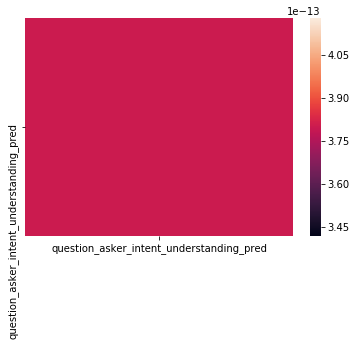

In [72]:
sns.heatmap(pd.DataFrame({"question_asker_intent_understanding_pred": [mean_squared_error(y_tr['question_asker_intent_understanding'],p1)] },index=['question_asker_intent_understanding_pred']))

In [62]:
spearmanr(y_tr['question_asker_intent_understanding'],p1,),spearmanr(y_vl['question_asker_intent_understanding'],p2,)

(SpearmanrResult(correlation=0.9366611035464459, pvalue=0.0),
 SpearmanrResult(correlation=0.24042441735570405, pvalue=1.3061719006022164e-21))

In [56]:
p2

array([0.94424616, 1.13224281, 0.7429134 , ..., 0.85900114, 0.87971332,
       0.79284082])

In [ ]:
fr

### 9.3. Training BOW model

In [107]:
# Dependent variable columns
x_columns = [features for features in train_df.columns if features not in target_vars]

X_train = train_df[x_columns]
y_train = train_df[target_vars]

kf = MultilabelStratifiedKFold(n_splits = 4, random_state = 9)

for ind, (tr, val) in enumerate(kf.split(X_train,y_train)):
    X_tr = X_train.iloc[tr]
    y_tr = y_train.iloc[tr]
    X_vl = X_train.iloc[val]
    y_vl = y_train.iloc[val]
    
    
    

    # 
    print(X_tr.shape,y_tr.shape,X_vl.shape,y_vl.shape,)
    

(4565, 84) (4565, 30) (1514, 84) (1514, 30)
(4565, 84) (4565, 30) (1514, 84) (1514, 30)
(4562, 84) (4562, 30) (1517, 84) (1517, 30)
(4545, 84) (4545, 30) (1534, 84) (1534, 30)


In [198]:
X_train[X_tr.index]

<4545x1083746 sparse matrix of type '<class 'numpy.float64'>'
	with 8420656 stored elements in Compressed Sparse Row format>

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,
            ...
            6067, 6068, 6069, 6070, 6071, 6072, 6073, 6076, 6077, 6078],
           dtype='int64', length=4545)

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

In [89]:
sgd_regressor = SGDRegressor()

In [90]:
param = {'loss':['squared_loss']}

In [91]:
gscv= GridSearchCV(sgd_regressor,
    param_grid = param,
    scoring="neg_mean_squared_error",
    cv=kf)

In [92]:
y_train['question_asker_intent_understanding']

0       1.000000
1       1.000000
2       1.000000
3       0.888889
4       0.888889
          ...   
6074    0.666667
6075    0.833333
6076    0.666667
6077    0.777778
6078    0.777778
Name: question_asker_intent_understanding, Length: 6079, dtype: float64

In [93]:
sgd_regressor.fit(X_train.iloc[:,30:35],np.array(y_train))

ValueError: bad input shape (6079, 30)

In [ ]:
X_train.iloc[:,30:35]

In [ ]:
gscv.fit(X_train.iloc[:,30:35],np.array(y_train['question_asker_intent_understanding']))

In [ ]:
all_predictions = []

rho_kfolds = []

kf = MultilabelStratifiedKFold(n_splits = NUM_FOLDS, random_state = SEED)
for ind, (tr, val) in enumerate(kf.split(X_train,y_train)):
    X_tr = X_train[tr]
    y_tr = y_train[tr]
    X_vl = X_train[val]
    y_vl = y_train[val]
    
    model = create_model()
    model.fit(
        X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_vl, y_vl), verbose=True, 
        callbacks=[SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl),
                                       patience=15, model_name=f'best_model_batch{ind}.h5')]
    )
    all_predictions.append(model.predict(X_test))

    y_pred_val = model.predict(X_vl)
    rho_list = [ spearmanr(y_vl[:, ind], y_pred_val[:, ind]).correlation for ind in range(y_pred_val.shape[1]) ]
    rho_kfolds.append(rho_list)

In [ ]:
from scipy.stats import spearmanr
print(spearmanr([1,2,3],[-0.00005,-0.00005,0]).correlation)
print(spearmanr([1,2,3],[-5,-5,-5]).correlation)
print(spearmanr([1,1,1],[-5,-4,-3]).correlation)